# Live VCC image data -> distgen xy_dist file

See https://github.com/slaclab/lcls-lattice/blob/master/distgen/models/cu_inj/vcc_image/vcc_image.ipynb for a better explanation

In [1]:
import epics
import numpy as np
import os

In [2]:
from skimage.filters import sobel
from skimage.util import img_as_ubyte
from skimage.segmentation import watershed
from skimage.filters.rank import median
from skimage.morphology import disk

In [3]:
#BASEPV = 'CAMR:IN20:186' # LCLS
#BASEPV = 'CAMR:LT10:900' # FACET-II

In [4]:
LCLS_VCC_PV = {
    
    'array':  'CAMR:IN20:186:IMAGE',
    'size_x': 'CAMR:IN20:186:N_OF_COL',
    'size_y': 'CAMR:IN20:186:N_OF_ROW',
    'resolution': 'CAMR:IN20:186:RESOLUTION',
    'resolution_units': 'CAMR:IN20:186:RESOLUTION.EGU'
    
    
}
#epics.caget_many(LCLS_VCC_PV.values())

In [5]:
FACET_VCC_PV = {
    
    'array': 'CAMR:LT10:900:Image:ArrayData',
    'size_x': 'CAMR:LT10:900:ArraySizeX_RBV',
    'size_y': 'CAMR:LT10:900:ArraySizeY_RBV',
    'resolution': 'CAMR:LT10:900:RESOLUTION',
    'resolution_units': 'CAMR:LT10:900:RESOLUTION.EGU'
    
    
}
#epics.caget_many(FACET_VCC_PV.values())

In [6]:
# Master dict
VCC_DEVICE_PV = {
    'CAMR:IN20:186':LCLS_VCC_PV,
    'CAMR:LT10:900':FACET_VCC_PV 
    
}

def get_vcc_data(vcc_device, pvdata=None):
    # Get actual PVs
    d = VCC_DEVICE_PV[vcc_device]
    
    if pvdata:
        values = [pvdata[k] for k in d.values()]
    else: 
        values = epics.caget_many(d.values())
    
    data =  dict(zip(d.keys(),values))
    # Make consistent units
    if data['resolution_units'] == 'um/px':
        data['resolution_units'] = 'um'
    return data
    
    
#get_vcc_data('CAMR:LT10:900')    


In [7]:
def isolate_image(img, fclip=0.08):
    """
    Uses a masking technique to isolate the VCC image
    """
    img=img.copy()
    
    # Clip lowest fclip fraction
    img[img < np.max(img)* fclip] = 0
    
    
    # Filter out hot pixels to use aas a mask
    # https://scikit-image.org/docs/0.12.x/auto_examples/xx_applications/plot_rank_filters.html
    img2 = median(img_as_ubyte(img), disk(2))
    
    elevation_map = sobel(img2)
    markers = np.zeros_like(img2)
    
    # TODO: tweak these numbers
    markers[img2 < .1] = 1
    markers[img2 > .2] = 2

    # Wateshed
    segmentation = watershed(elevation_map, markers)
    
    # Set to zero in original image
    img[np.where(segmentation != 2)]  = 0 
    
    # 
    ixnonzero0 = np.nonzero(np.sum(img2, axis=1))[0]
    ixnonzero1 = np.nonzero(np.sum(img2, axis=0))[0]
    
    i0, i1, j0, j1 = ixnonzero0[0], ixnonzero0[-1], ixnonzero1[0], ixnonzero1[-1]
    cutimg = img[i0:i1,j0:j1]
    
    return cutimg

In [8]:
def write_distgen_xy_dist(filename, image, resolution, resolution_units='m'):
    """
    Writes image data in distgen's xy_dist format
    
    Returns the absolute path to the file written
    
    """
    
    # Get width of each dimension
    widths = resolution * np.array(image.shape)
    
    center_y = 0
    center_x = 0
    
    # Form header
    header = f"""x {widths[1]} {center_x} [{resolution_units}]
y {widths[0]} {center_y}  [{resolution_units}]"""
    
    # Save with the correct orientation
    np.savetxt(filename, np.flip(image, axis=0), header=header, comments='')
    
    return os.path.abspath(filename)

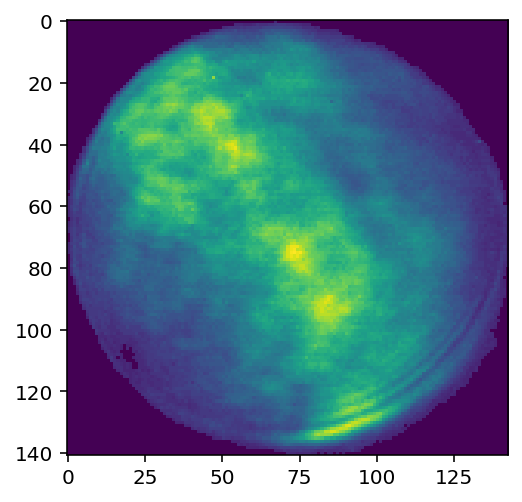

In [9]:
def get_live_distgen_xy_dist(filename='test.txt', vcc_device='CAMR:IN20:186', pvdata=None, fclip=0.08):
    
    # Get data
    dat = get_vcc_data(vcc_device, pvdata)
    
    arr = dat['array']
    image = arr.reshape(dat['size_y'], dat['size_x'])
        
    cutimg = isolate_image(image, fclip=fclip)
    
    assert cutimg.ptp() > 0
        
    fout = write_distgen_xy_dist(filename, cutimg, dat['resolution'], resolution_units=dat['resolution_units'])
    
    return fout, image, cutimg
    
   
# import matplotlib.pyplot as plt
# %config InlineBackend.figure_format = 'retina'
# fout, i1, i2 = get_live_distgen_xy_dist(vcc_device='CAMR:IN20:186')
# #fout, i1, i2 = get_live_distgen_xy_dist(vcc_device='CAMR:LT10:900', fclip=0.08)
# 
# plt.imshow(i2)
# 

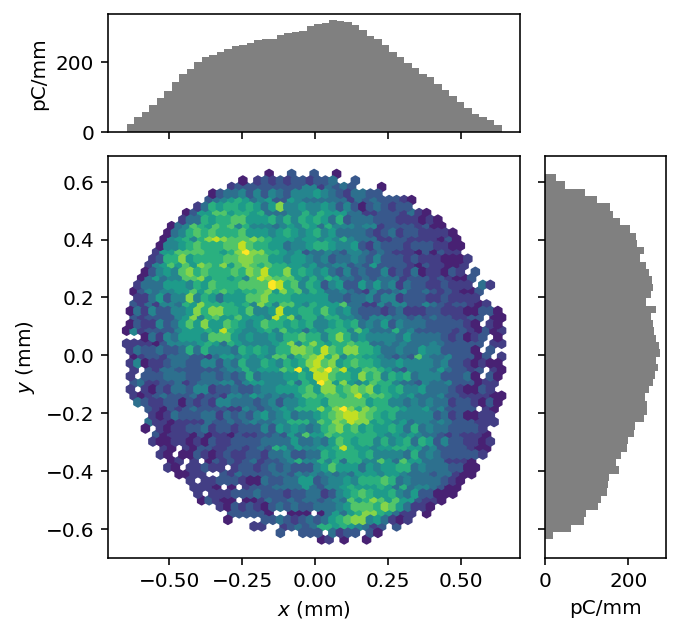

In [10]:
# #gfile = os.path.expandvars('$FACET2_LATTICE/distgen/models/f2e_inj/vcc_image/distgen.yaml')
# gfile = os.path.expandvars('$LCLS_LATTICE/distgen/models/cu_inj/vcc_image/distgen.yaml')
# from distgen import Generator
# 
# G = Generator(gfile)
# G['xy_dist:file'] = fout
# G['n_particle'] = 10000
# G.run()
# G.particles.plot('x', 'y', figsize=(5,5))

In [ ]:
# PVDATA = dict(zip(FACET_VCC_PV.values(), epics.caget_many(FACET_VCC_PV.values())))
# PVDATA

In [ ]:
# fout, i1, i2 = get_live_distgen_xy_dist(vcc_device='CAMR:LT10:900', pvdata=PVDATA)
# plt.imshow(i2)